# How to start

Before starting you must:
- Ensure that `scipp` and `mantid` are on your `PYTHONPATH`.
- Generate the `scippconfig.py` file using `make_config.py` located in same directory as this notebook. Refer to the `README.md` or `python make_config.py --help` for information.
- Install dependencies : `conda install fabio tifffile` (used for image handling)

For `scipp` and `mantid` follow instructions at: https://scipp.readthedocs.io/en/latest/getting-started/installation.html.

Converted to use scipp and notebook from [this repository](https://git.esss.dk/testbeamline/gp2/-/tree/stressexperiment).

For Table of Contents install Jupyter extensions then reload the notebook:
`conda install -c conda-forge jupyter_contrib_nbextensions`
`jupyter contrib nbextension install --user`
`jupyter nbextension enable toc2/main`

# Experimental Summary

This script has been developed to measure local strain ε defined as ε = ΔL/L0 in a FCC steel sample under elastic strain in a stress rig. Measured at V20, HZB, Berlin, September 2018 by Peter Kadletz.

λ = 2dsinθ, where 2θ = π (transmission), edges characterise the Bragg condition and hence λ = 2d. Therefore strain is easily computed from the wavelength measurement of of a Bragg edge directly, using un-loaded vs loaded experimental runs (and reference mesurements). The known Miller indices of the crystal structure (FCC) are used to predict the wavelength where the Bragg edges should exist, which is bound by the reachable wavelength extents for the instrument. This provides an approximate region to apply a fit.  A complement error function is used to fit each Bragg edge, and a refined centre location (λ) for the edge is used in the strain measurement. Because each bragg edge can be identified individually, one can determine anisotropic strain across the unit cell in the reachable crystallographic directions. In addition the image processing allows for spacial grouping so localised effects, such as those on unconstrained edges of the sample or in necking regions of the sample can be treated seperately. The plotted outputs in the script aim to capture this.


# How to start

Before starting you must:
- Ensure that `scipp` and `mantid` are on your `PYTHONPATH`.
- Generate the `scippconfig.py` file using `make_config.py` located in same directory as this notebook. Refer to the `README.md` or `python make_config.py --help` for information.
- Install dependencies : `conda install fabio tifffile` (used for image handling)

For `scipp` and `mantid` follow instructions at: https://scipp.readthedocs.io/en/latest/getting-started/installation.html.

Converted to use scipp and notebook from [this repository](https://git.esss.dk/testbeamline/gp2/-/tree/stressexperiment).

For Table of Contents install Jupyter extensions then reload the notebook:
`conda install -c conda-forge jupyter_contrib_nbextensions`
`jupyter contrib nbextension install --user`
`jupyter nbextension enable toc2/main`

# Experimental Summary

This script has been developed to measure local strain ε defined as ε = ΔL/L0 in a FCC steel sample under elastic strain in a stress rig. Measured at V20, HZB, Berlin, September 2018 by Peter Kadletz.

λ = 2dsinθ, where 2θ = π (transmission), edges characterise the Bragg condition and hence λ = 2d. Therefore strain is easily computed from the wavelength measurement of of a Bragg edge directly, using un-loaded vs loaded experimental runs (and reference mesurements). The known Miller indices of the crystal structure (FCC) are used to predict the wavelength where the Bragg edges should exist, which is bound by the reachable wavelength extents for the instrument. This provides an approximate region to apply a fit.  A complement error function is used to fit each Bragg edge, and a refined centre location (λ) for the edge is used in the strain measurement. Because each bragg edge can be identified individually, one can determine anisotropic strain across the unit cell in the reachable crystallographic directions. In addition the image processing allows for spacial grouping so localised effects, such as those on unconstrained edges of the sample or in necking regions of the sample can be treated seperately. The plotted outputs in the script aim to capture this.





# Script setup

In [8]:
try:
    import scipp
except ImportError as e:
    print("scipp is not available in the PYTHONPATH")
    raise e
    
try:
    import mantid
except ImportError as e:
    print("mantid is not available in the PYTHONPATH")
    raise e
    
try:
    import scippconfig
except ImportError as e:
    print("scippconfig is not available. Make sure you have generated it with `make_config.py`.")
    raise e

## Set input and output dirs

If your input directory has a different structure this is the cell to modify. 
Additionally the output directory can be renamed too.

In [9]:
# Lets get everything set up
import os
import sys

import scipp as sc
import numpy as np

import imaging, operations

from scipy import ndimage, signal

DATA_DIR_NAME = "data_GP2"
OUTPUT_DIR_NAME = "output"

data_dir = os.path.join(scippconfig.script_root, DATA_DIR_NAME)
output_dir = os.path.join(scippconfig.script_root, OUTPUT_DIR_NAME)
instrument_file = os.path.join(scippconfig.script_root, 'IDF', 'V20_Definition_GP2.xml')

tofs_path = os.path.join(data_dir, 'metadata', 'GP2_Stress_time_values.txt')
raw_data_dir = os.path.join(data_dir, "Stress_Experiments")

if not os.path.exists(data_dir):
    raise FileNotFoundError("The following data directory does not exist,"
                            f" check your make_config.py:\n{data_dir}")

## Reduction Options

In [10]:
# Customisable Options:

# defining grouping of 2D detector pixels
grouping_number = 27
nx_target = grouping_number
ny_target = grouping_number

bin_width = (64 * 2.5)  # μS

# Rebin regions for each of the 5 WFM frames. Values are in detector time : μS
# in the format of [bin-start, bin-end, bin width].
# used to crop each image, before stitching them together
frame_parameters = [{"start": 15450, "stop":22942, "step":bin_width},
                    {"start": 24800, "stop":32052, "step":bin_width},
                    {"start": 33791, "stop":40084, "step":bin_width},
                    {"start": 41763, "stop":47457, "step":bin_width},
                    {"start": 49315, "stop":54500, "step":bin_width},
                    {"start": 56500, "stop":58360, "step":bin_width}]

# Used to rebin the summed frame in order to
# cut off frames that contain no data
rebin_parameters = {"start":8550, "stop":26000, "step":bin_width}

# Used to shift the cropped frames so that their bins overlap
# before summing them together into a single frame
frame_shift_increments = [-6630, -2420, -2253, -2095, -1946, -1810]
frame_shift_increments = [float(i) for i in frame_shift_increments]  # Work around #1114

# Pulse references
pulse_number_reference = 1.0 / 770956
pulse_number_sample = 1.0 / 1280381
pulse_number_sample_elastic = 1.0 / 2416839
pulse_number_sample_plastic = 1.0 / 2614343

# units of transmission, all pixels with transmission higher masking threshold are masked
masking_threshold = 0.80

# Toggles outputting masked and sliced tiff stacks
output_tiff_stack = True

# Experiment Metadata
measurement_number = 11

# Reduction

## Load and scale

In [11]:
# let's get the process started:

# Load X values from the TOF file. Though raw contents are NOT TOF corrected yet.
ds = sc.Dataset()
ds.coords["t"] = sc.Variable(["t"], unit=sc.units.us, values=imaging.read_x_values(tofs_path))
ds.coords["t"] *= 1e3

def load_and_scale(folder_name, scale_factor):
    to_load = os.path.join(raw_data_dir, folder_name)
    variable = imaging.tiffs_to_variable(to_load)
    variable *= scale_factor
    return variable

ds["reference"] = load_and_scale(folder_name="1) R825 Open Beam", scale_factor=pulse_number_reference)
ds["sample"] = load_and_scale(folder_name="2) R825", scale_factor=pulse_number_sample)
ds["sample_elastic"] = load_and_scale(folder_name="3) R825 600 Mpa", scale_factor=pulse_number_sample_elastic)

Loading 1001 files from '/Users/spu92482/ownCloud2/RAL_Mantid_Sep2018/data_GP2/Stress_Experiments/1) R825 Open Beam'
GP2_034_Open_Beam1000.tiff: Image 1001, of 1001
Loading 1001 files from '/Users/spu92482/ownCloud2/RAL_Mantid_Sep2018/data_GP2/Stress_Experiments/2) R825'
GP2_035_R8251000.tiff: Image 1001, of 1001
Loading 1001 files from '/Users/spu92482/ownCloud2/RAL_Mantid_Sep2018/data_GP2/Stress_Experiments/3) R825 600 Mpa'
GP2_036_R825_600Mpa1000.tiff: Image 1001, of 1001


## Add Spectra Coords

In [12]:
# Adds a coordinate for the spectrum
ds.coords["spectrum"] = sc.Variable(["spectrum"], values=np.arange(ds["sample"].shape[1]))


<IPython.core.display.Javascript object>


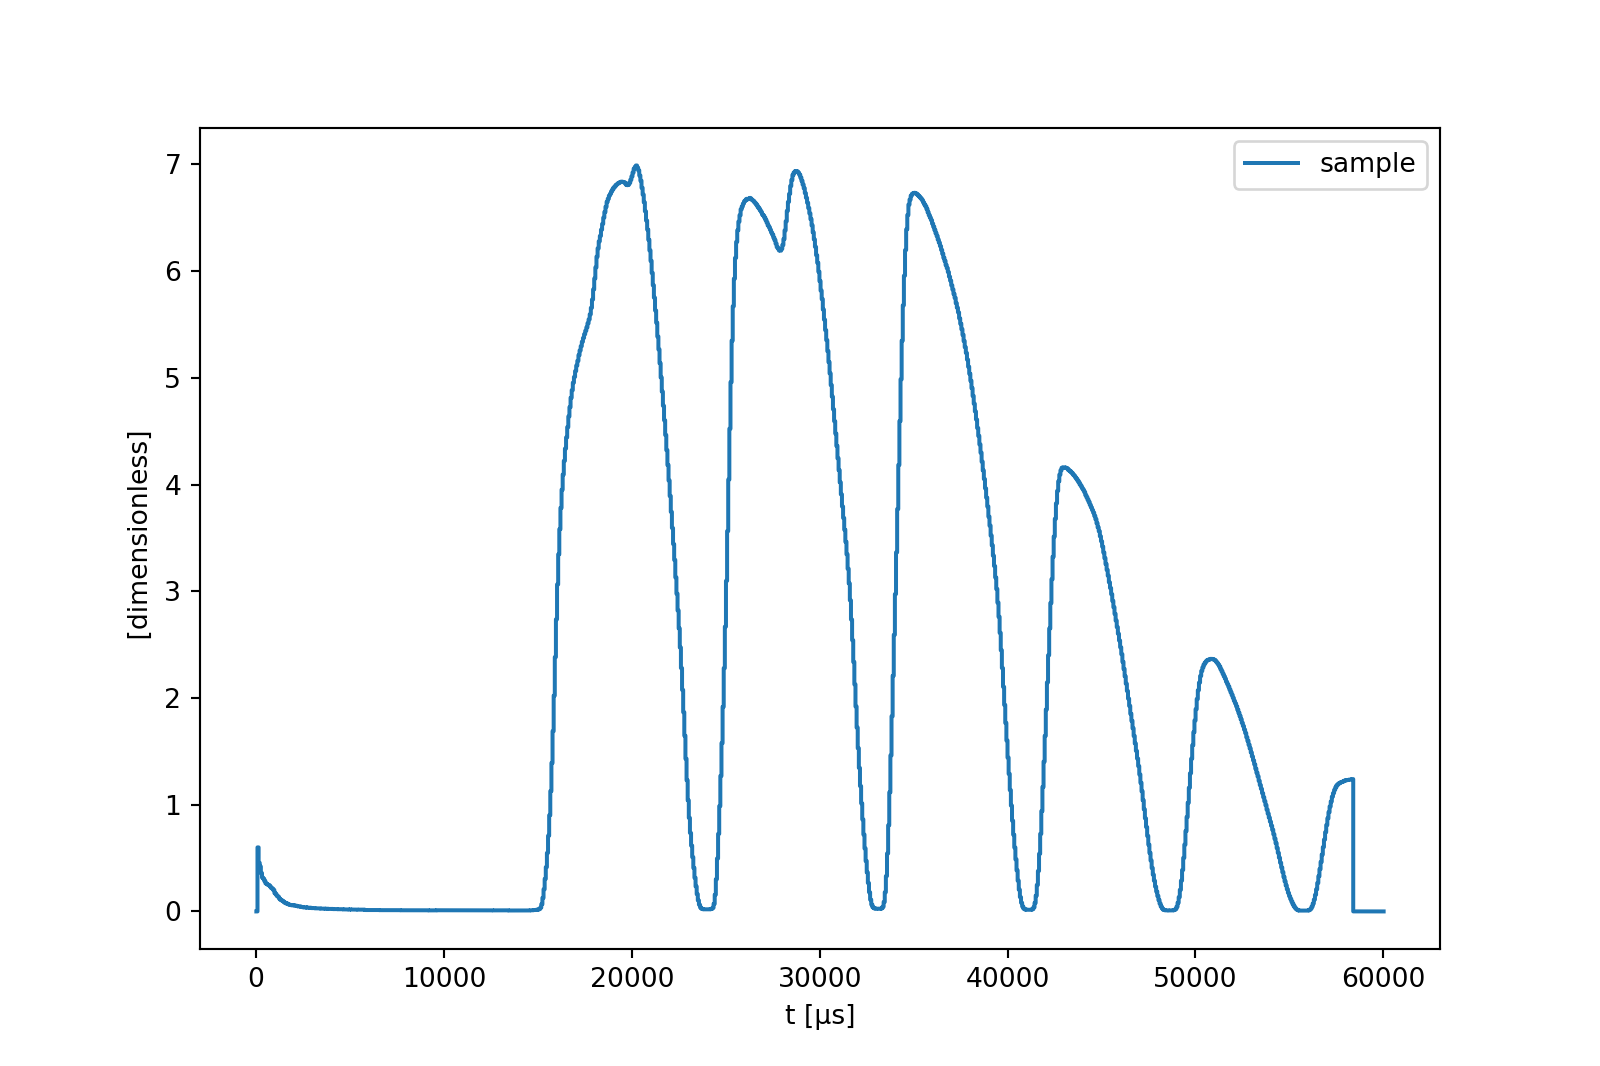

In [31]:
sc.plot.plot(sc.sum(ds['sample'], dim='spectrum'))

## Frame shifts and stitching

Pre-calculated frame shifts. This will be replaced with automatic WFM stitching in the future

In [13]:
# TODO use Neil's wfmess, or similar to avoid hard-coding the edges. This approach is not very nice.
frame_shifts = [sum(frame_shift_increments[:i + 1]) for i in range(len(frame_shift_increments))]

def stitch(ds, frame_parameters, frame_shifts, rebin_parameters):
    """
    Stitches the 5 wfm frames data.
    It crops out each frame, then shifts it so that all frames align,
    and then rebins to the operations bins used for all frames.
    """
    frames = []

    rebin_params = sc.Variable(["t"], unit=sc.units.us,
                               values=np.arange(**rebin_parameters))

    for i, (slice_bins, shift_parameter) in enumerate(
            zip(frame_parameters, frame_shifts)):
        bins = sc.Variable(["t"], values=np.arange(**slice_bins))
        # Rebins the whole data to crop it to frame bins
        rebinned = sc.rebin(ds, "t", bins)
        # Shift each frame according to time shift (function of frequency and window opening)
        rebinned.coords["t"] += shift_parameter # Now in TOF
        # Rebin to overarching coordinates so that the frame coordinates align
        rebinned = sc.rebin(rebinned, "t", rebin_params)

        frames.append(rebinned)
    
    # All frames now shifted and therefore represent actual TOF. Frames can be summed.
    for f in frames[1:]:
        frames[0] += f

    frames[0].rename_dims({'t':'tof'})
    return frames[0]

# Comparing ["sample"]["spectrum", 37000] data stops matching, as Mantid
# and skip appear to handle to partial bin at the end differently. This results
# in different counts making data comparison difficult

stitched = stitch(ds, frame_parameters=frame_parameters,frame_shifts=frame_shifts,rebin_parameters=rebin_parameters)



<IPython.core.display.Javascript object>


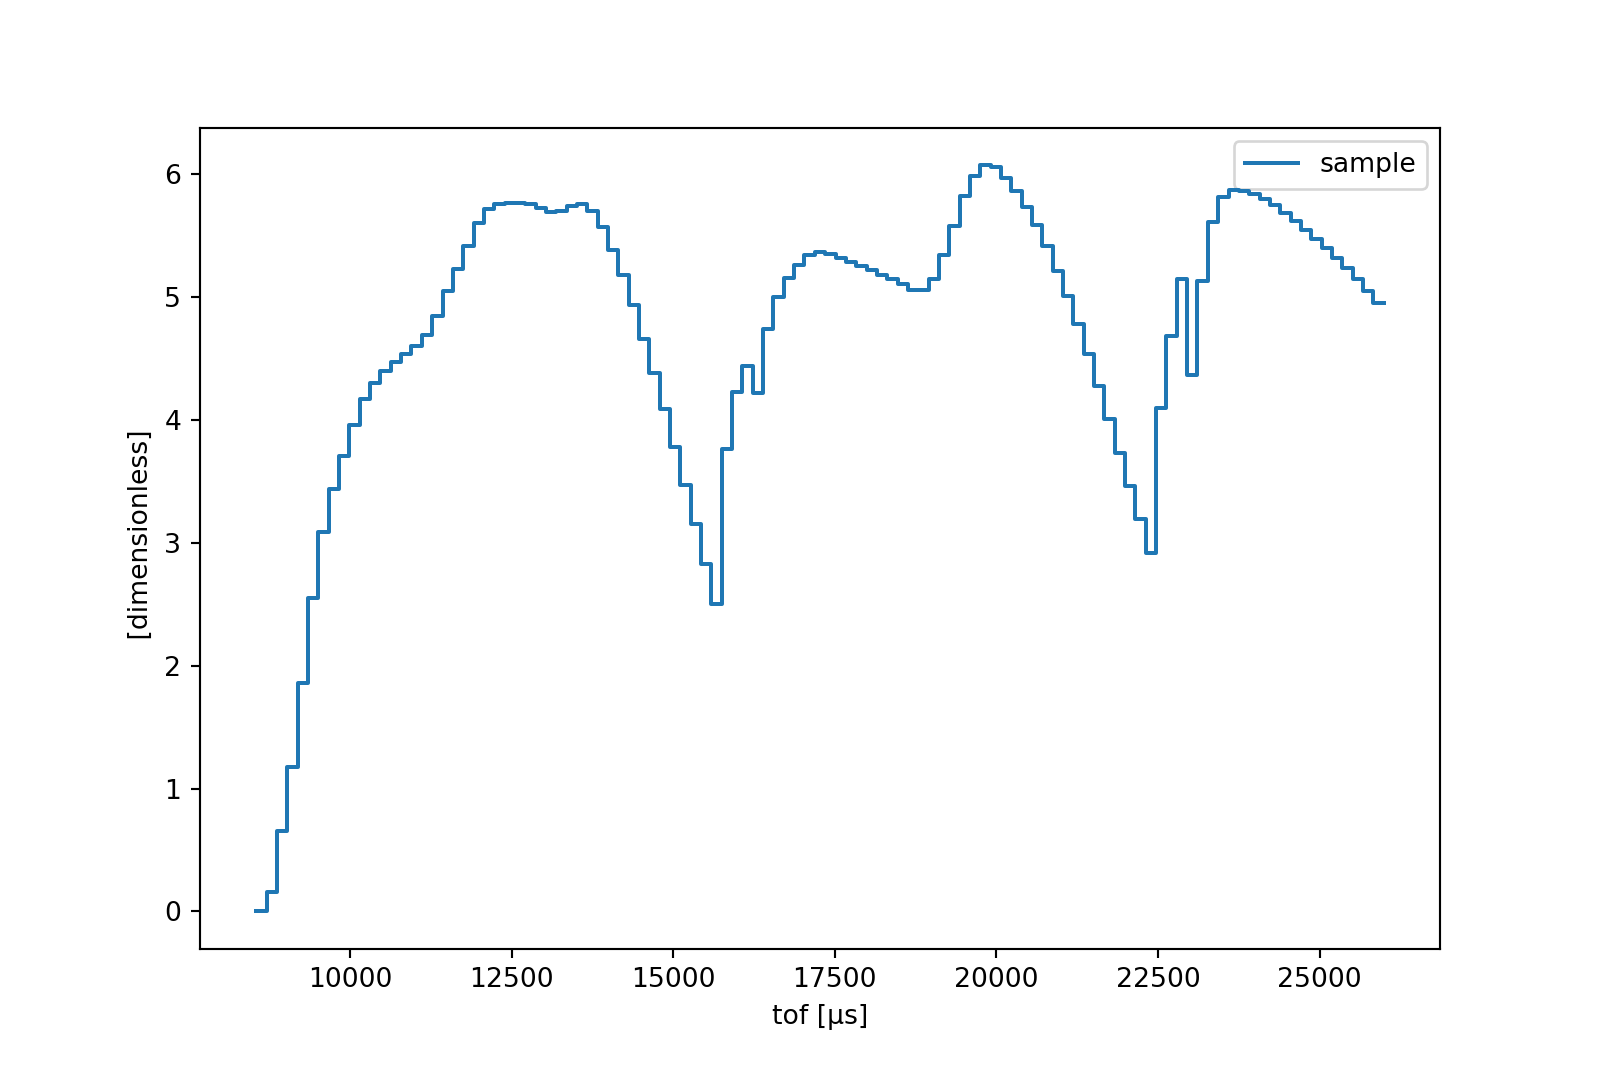

In [32]:
sc.plot.plot(sc.sum(stitched['sample'], dim='spectrum'))

## Masking
### Integration step

Integrate counts for each spectra by summing over TOF

In [14]:
integrated = sc.sum(stitched, 'tof')

# Pull out reference from out dataset to avoid checking for it in loops
reference = stitched["reference"].copy()
integrated_reference = integrated["reference"].copy()

del stitched["reference"]
del integrated["reference"]

### Transmission Masking

Divides the integrated sample counts with an open beam reference. Any values > masking threshold
will be masked. The adj pixels step checks for random pixels which were left unmasked or masked
with all their neighbours having the same mask value. These are forced to True or false depending on
their neighbour value.

<IPython.core.display.Javascript object>


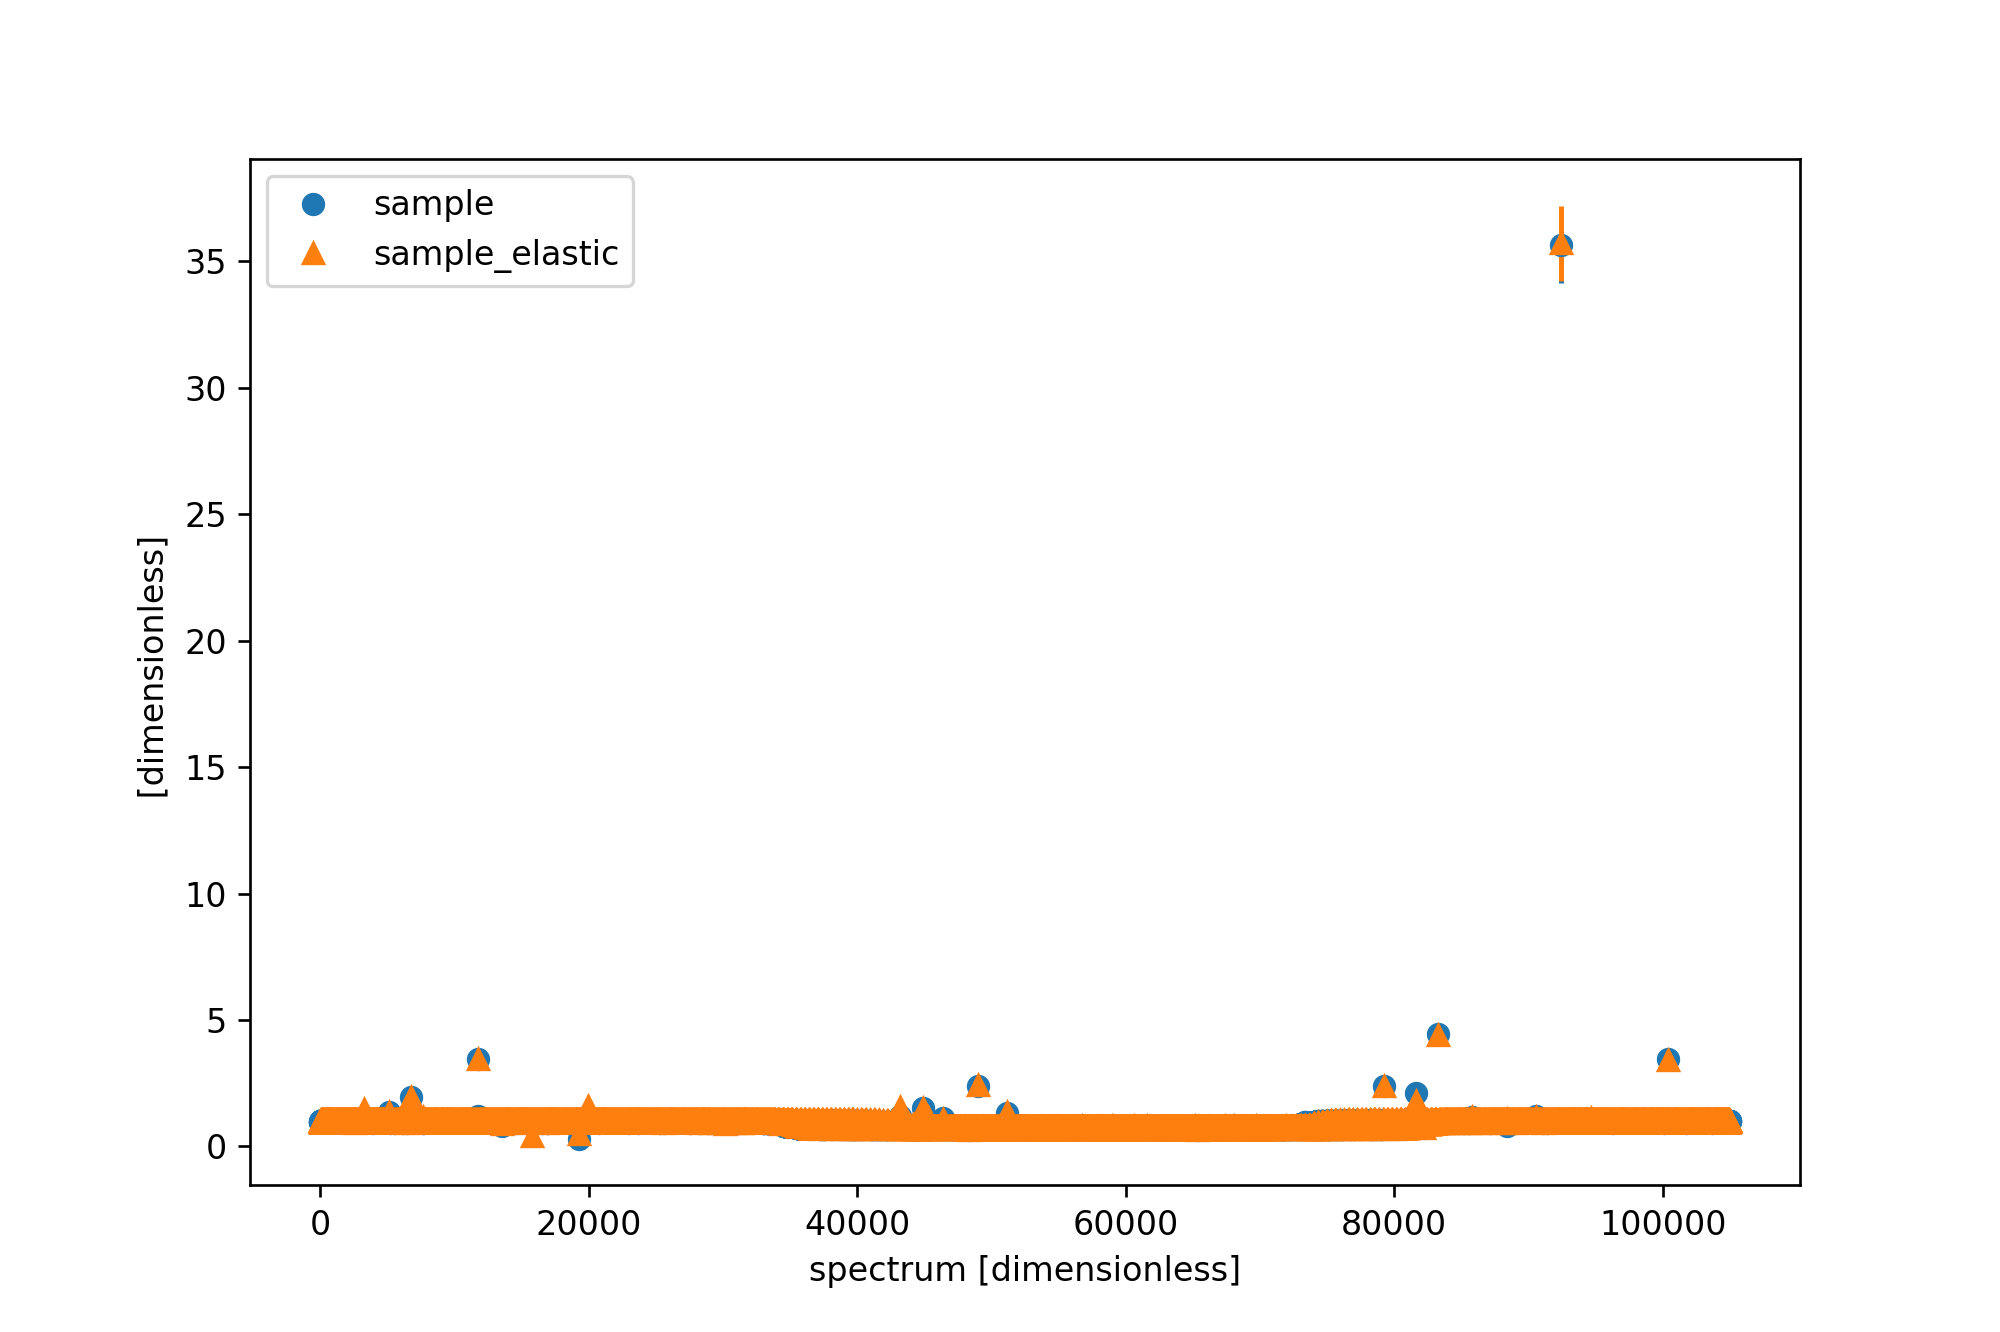

Masking non-sample regions in sample
sample     <scipp.Variable>          int64      [dimensionless]  ()  [64083]

Exporting tiff stack for sample
Saved sample_norm_sum_0000.tiff stack.
Saved tof_of_tiff_sample_norm_sum.txt.

Masking non-sample regions in sample_elastic
sample_elastic     <scipp.Variable>          int64      [dimensionless]  ()  [64156]

Exporting tiff stack for sample_elastic
Saved sample_elastic_norm_sum_0000.tiff stack.
Saved tof_of_tiff_sample_elastic_norm_sum.txt.



<ipython-input-15-69cf302ddbfb>:8: RuntimeWarning: invalid value encountered in greater
  spectra_masks = np.greater(integrated_spectra.values, masking_threshold)


In [15]:
num_spectra = stitched.coords["spectrum"].shape[0]
bank_width = int(np.sqrt(num_spectra))

def mask_non_sample_regions(integrated_dataset, stitched_dataset, var_name):
    integrated_spectra = integrated_dataset[var_name]

    # This should use sc.greater once #1178 is completed
    spectra_masks = np.greater(integrated_spectra.values, masking_threshold)
    spectra_masks = sc.Variable(["spectrum"], values=spectra_masks)

    # Some pixels may be noisy / not strong enough signal so they erranously
    # become unmasked / masked from the above operation. This step checks if *all*
    # the surrounding pixels are True or False then sets the center pixel to
    # that value if they are, removing "salt and pepper" noise
    spectra_masks = sc.reshape(spectra_masks, dims=["y", "x"], shape=(bank_width, bank_width))

    final_mask = operations.mask_from_adj_pixels(spectra_masks)
    return sc.Variable(["spectrum"], values=final_mask.values.ravel())

# Calculate transmission value for all

int_norm = integrated / integrated_reference
sc.plot.plot(int_norm)

# Store TOF coords back for the export to TIFF stack
tof_coords = stitched.coords["tof"]

for k in integrated.keys():
    print(f"Masking non-sample regions in {k}")

    p = mask_non_sample_regions(int_norm, stitched, k)
    print(k, sc.sum(p, dim='spectrum'))
    stitched[k].masks['non-sample-region'] = mask_non_sample_regions(int_norm, stitched, k)

    if output_tiff_stack:
        print(f"Exporting tiff stack for {k}")
        tiff_out_dir = os.path.join(output_dir, f"tiffs_tof_sum_{k}")
        imaging.export_tiff_stack(dataset=int_norm, key=k,
                                  base_name=f"{k}_norm_sum",
                                  output_dir=tiff_out_dir,
                                  x_len=324, y_len=324,
                                  tof_values=tof_coords.values)
        # Print a newline to prevent the saving messages overlapping
        print()

In [28]:
stitched

<scipp.Dataset>
Dimensions: {{tof, 109}, {spectrum, 104976}}
Coordinates:
    spectrum                  int64      [dimensionless]  (spectrum)  [0, 1, ..., 104974, 104975]
    tof                       float64    [μs]            (tof [bin-edges])  [8550.000000, 8710.000000, ..., 25830.000000, 25990.000000]
Data:
    sample                    float64    [dimensionless]  (tof, spectrum)  [0.000000, 0.000000, ..., 0.000162, 0.000207]  [0.000000, 0.000000, ..., 0.000000, 0.000000]
    Masks:
            non-sample-region         bool       [dimensionless]  (spectrum)  [True, True, ..., True, True]
    sample_elastic            float64    [dimensionless]  (tof, spectrum)  [0.000000, 0.000000, ..., 0.000166, 0.000197]  [0.000000, 0.000000, ..., 0.000000, 0.000000]
    Masks:
            non-sample-region         bool       [dimensionless]  (spectrum)  [True, True, ..., True, True]

## Normalization

In [16]:
# Normalize by open beam
normalized = stitched / reference

# Replace special values nan and inf
replacement=sc.Variable(value=0.0, variance=0.0)
kwargs = {"nan" : replacement, "posinf" : replacement, "neginf" : replacement}
for k in normalized.keys():
    sc.nan_to_num(normalized[k].data, out=normalized[k].data, **kwargs)

### Output Intermediate

In [17]:
if output_tiff_stack:
    tof_values = normalized.coords["tof"].values

    imaging.export_tiff_stack(dataset=normalized, key="sample", x_len=324, y_len=324,
                              base_name="initial_tof", output_dir=os.path.join(output_dir, "tiffs_tof_initial"),
                              tof_values=tof_values)
    imaging.export_tiff_stack(dataset=normalized, key="sample_elastic", x_len=324, y_len=324,
                              base_name="elastic_tof", output_dir=os.path.join(output_dir, "tiffs_tof_elastic"),
                              tof_values=tof_values)

Saved initial_tof_0000.tiff stack.
Saved tof_of_tiff_initial_tof.txt.
Saved elastic_tof_0000.tiff stack.
Saved tof_of_tiff_elastic_tof.txt.


## Convert to wavelength

In [18]:
# Load in IDF for positions of source/sample...etc
sc.compat.mantid.load_component_info(normalized, instrument_file)
wavelength = sc.neutron.convert(normalized, "tof", "wavelength")

## Apply filter function

In [19]:
%%time
filter_func = operations.mean_from_adj_pixels # Mean filter
#filter_func = operations.median_from_adj_pixels # Median filter
for k in wavelength.keys():
    print(f'{filter_func.__name__} filter over {k}')
    yx = sc.reshape(wavelength[k].data, dims=["wavelength", "y", "x"], shape=(wavelength[k].shape[0], bank_width, bank_width))
    xy_filtered = filter_func(yx)
    wavelength[k].data = sc.reshape(xy_filtered, dims=["wavelength", "spectrum"], shape=(wavelength[k].shape[0],wavelength[k].shape[1]) )


mean_from_adj_pixels filter over sample
mean_from_adj_pixels filter over sample_elastic
CPU times: user 21.7 s, sys: 20.3 s, total: 42.1 s
Wall time: 23.2 s


## Rebin to common bin width

As each detector has a different relative position to the sample we
need to rebin to a common set of wavelength bins for all

In [20]:
wav_x_vals = wavelength["sample"].coords["wavelength"]
start_wave = sc.min(wav_x_vals)
stop_wave = sc.max(wav_x_vals)

widths = wav_x_vals['wavelength', 1:] - wav_x_vals['wavelength', :-1]
bin_width = sc.mean(sc.mean(widths, 'wavelength'), 'spectrum')
# Arange does not include final bin so overshoot
stop_wave += bin_width

wavelength_coords = sc.Variable(["wavelength"], values=np.arange(start_wave.value, stop_wave.value,
                                                                 bin_width.value))
rebinned_wavelength = sc.rebin(wavelength, "wavelength", wavelength_coords)


group_size = (324.0  / nx_target) * (324.0 / ny_target)
factor = group_size
rebinned_wavelength["sample"] *= factor

## Sample - Sum Spectra

Performs a weighted sum for all spectra in the sample 

In [21]:
def weighted_sum(da : sc.DataArrayView, dim):
    
    variances = sc.variances(da.data)
    data = da / variances
    norm = sc.DataArray(data=sc.reciprocal(variances), masks=dict(da.masks.items()))
    data.masks['zero_error'] = sc.equal(variances, 0.0 * variances.unit)
    norm.masks['zero_error'] = sc.equal(variances, 0.0 * variances.unit)
    return sc.sum(data, dim) / sc.sum(norm, dim)

# If we are not interested in strain regions for the unloaded sample, we can just combine all spectra to improve statistics.
# maybe another masking before summation, with tougher threshold to exclude boderline pixels.
sample_final = weighted_sum(rebinned_wavelength["sample"], "spectrum")

## Sample elastic - Group detectors

Group detectors instead of summing all, since the elastic deformation could
happen at any point we want a balance between signal-noise ratio and 
resolution.

In [22]:
rebinned_wavelength.coords["spectrum_mapping"] = imaging.make_detector_groups(bank_width, bank_width,
                                                                              nx_target, ny_target)

# Group detectors for the sample_elastic / sample_plastic
grouped = sc.groupby(rebinned_wavelength, "spectrum_mapping").sum("spectrum")
grouped_sample_elastic = grouped["sample_elastic"]

## Pre-calculate detector positions

Pre-calculate average detector positions for plotting later

In [23]:
histogram_matrices = [sample_final, grouped_sample_elastic]
template_histogram = histogram_matrices[1]

# Average out detector positions
positions_dataset = sc.Dataset()
positions_dataset["position"] = sc.Variable(rebinned_wavelength.coords["position"])
positions_dataset.coords["spectrum_mapping"] = rebinned_wavelength.coords["spectrum_mapping"]
grouped_positions = sc.groupby(positions_dataset, "spectrum_mapping").mean("spectrum")

plots = []
for spec_idx in template_histogram.coords["spectrum_mapping"].values:
    pos = grouped_positions["position"]["spectrum_mapping", int(spec_idx)]
    # Append spectrum index and position
    plots.append((spec_idx,pos))

# We cant access position using (dim, I), since the vector 3d has not dim currently
Y_key = 1
X_key = 0

# We must use round to prevent floating points errors during sorting like -0.05 > 0.05
# Sort by y then by x across image plots contain tuples of (spec_index to position), sort by position y, x
plots.sort(key=lambda t: (round(-t[1].value[Y_key], 10), round(t[1].value[X_key], 10)))

# Fitting
## Calculate expected Bragg edge positions 

In [24]:
# Bragg edge position roughly, in Angstrom
FCC_a = 3.5 # Angstrom, taken from COD entry 9008469

# These miller indices for the given unit cell yield bragg edges between the maximum and minimum wavelength range. 
#  TODO. should probably calculate which are visible from larger set.
indices_FCC = [(1,1,1),(2,0,0),(2,2,0),(3,1,1)]

def create_Braggedge_list(lattice_constant, miller_indices):
    '''
    :param miller-indices: like [(1,1,0),(2,0,0),...]
    :type miller-indices: list of tuples
    '''
    coords = [str((h, k, l)) for h, k, l in miller_indices]    
    interplanar_distances = [2.*lattice_constant/np.sqrt(h**2+k**2+l**2) for h, k, l in miller_indices]

    d = sc.DataArray(sc.Variable(dims=["bragg-edge"], values=np.array(interplanar_distances),
                                  unit=sc.units.angstrom))
    d.coords["miller-indices"] = sc.Variable(dims=["bragg-edge"], values=coords)
    return d


Bragg_edges_FCC = create_Braggedge_list(FCC_a, indices_FCC)

## Bragg-edge fitting

Fit Bragg-edge peaks for the sample initially. Then take this value to find the position within a window
for the elastic sample.

In [25]:

def Bragg_edge_position(xpos_Bragg_edge,x_min_sides,x_max_sides,x_size,y_size,plots):
    '''Takes limits around a roughly known Bragg edge and fits the Bragg edge to obtain
    its exact position. Needs the size (x_size, y_size) and the workspaces containing histogram arrays/matrices.
    x_min_side and x_max_side are arbitrary values and are calculated:
    bragg_edge_pos * x_min_side or bragg_edge_pos * x_max_side.
    '''

    fit_list = []
    spectrum_list_fitted_sample = []
    spectrum_list_fitted_sample_elastic = []
    elastic_ws = grouped_sample_elastic
    sample_ws = sample_final

    # loop for each Bragg edge in the list, find edge positions and save spectrums in lists
    for edge_index in range(xpos_Bragg_edge.shape[0]):
        fit_list.append([])
        spectrum_list_fitted_sample.append([])
        spectrum_list_fitted_sample_elastic.append([])

        bragg_edge = xpos_Bragg_edge.coords["miller-indices"]["bragg-edge", edge_index]

        xpos_guess = xpos_Bragg_edge["bragg-edge", edge_index].value
        x_min_fit = xpos_guess - xpos_guess * abs(x_min_sides[edge_index])
        x_max_fit = xpos_guess + xpos_guess * abs(x_max_sides[edge_index])

        print("Now fitting Bragg edge {} at {:.3f} A (between {:.3f} A and {:.3f} A) across image groups"
              .format(bragg_edge, xpos_guess, x_min_fit, x_max_fit))

        # if the full inital sample was taken and no grouping was done
        #Fitting the masked sample
        params_s, diff_s = sc.compat.mantid.fit(sample_ws, mantid_args={
                                      'Function':f'name=LinearBackground,A0={230},A1={-4};name=UserFunction,Formula=h*erf(a*(x-x0)),h={16},a={-11},x0={xpos_guess}',
                                      'StartX':x_min_fit, 'EndX':x_max_fit})

        v_and_var_s=[params_s.data['parameter', i] for i in range(params_s['parameter',:].shape[0])] 
        params = dict(zip(params_s.coords["parameter"].values, v_and_var_s))
        d_sample = params["f1.x0"] / 2.0 # See fit table definition for extract x0
       
        plot_cell_idx = 0 
        for row in range(y_size):
            for col in range(x_size):
                spectrum_idx = int(plots[plot_cell_idx][0])
                
                # Fit Bragg edge using values from fit of unstrained sample
                elastic_function = f"name=LinearBackground,A0={params['f0.A0'].value},A1={params['f0.A1'].value};name=UserFunction,Formula=h*erf(a*(x-x0)),h={params['f1.h'].value},a={params['f1.a'].value},x0={params['f1.x0'].value}"
                params_e, diff_e = sc.compat.mantid.fit(elastic_ws['spectrum_mapping', spectrum_idx], mantid_args={'Function':elastic_function,
                                                   'StartX':x_min_fit, 'EndX':x_max_fit})
                
                v_and_var_e=[params_e.data['parameter', i] for i in range(params_e['parameter',:].shape[0])] 
                elastic_params = dict(zip(params_e.coords["parameter"].values, v_and_var_e))
                d_sample_elastic = elastic_params["f1.x0"] / 2.0 # See fit table definition for extract x0
                lattice_strain = d_sample_elastic - d_sample

                # define successful fitting
                success = (params_s.coords["status"].value == "success") and (params_e.coords["status"].value == "success")

                # fitted values STORED in list
                fit_list[edge_index].append((spectrum_idx, (row, col), bragg_edge, d_sample, d_sample_elastic, lattice_strain, success))

                # workspace created from sample fit, workspace index 1 for fitted spectrum (index 0 for data, index 2 for difference curve)
                fitted_sample = diff_s['calculated'].values

                if params_s.coords["status"].value == "success":
                    spectrum_list_fitted_sample[edge_index].append((diff_s.coords["wavelength"].values, fitted_sample))
                else:
                    spectrum_list_fitted_sample[edge_index].append((diff_s.coords["wavelength"].values,
                                                           np.zeros_like(fitted_sample)))
                    
                fitted_elastic = diff_e['calculated'].values
                # workspace created from fit of sample under elastic deformation
                if params_e.coords["status"].value == "success":
                    spectrum_list_fitted_sample_elastic[edge_index].append((diff_e.coords["wavelength"].values, fitted_elastic))
                else:
                    spectrum_list_fitted_sample_elastic[edge_index].append((diff_e.coords["wavelength"].values,
                                                                                               np.zeros_like(fitted_elastic)))
                plot_cell_idx +=1

    return fit_list, spectrum_list_fitted_sample, spectrum_list_fitted_sample_elastic

fit_list, spectrum_list_fitted_sample, spectrum_list_fitted_sample_elastic = \
    Bragg_edge_position(xpos_Bragg_edge=Bragg_edges_FCC,
                                      x_min_sides=[0.05, 0.1, 0.1, 0.05],#[0.1, 0.1, 0.1, 0.05]
                                      x_max_sides=[0.1, 0.05, 0.1, 0.1],#[0.1, 0.1, 0.1, 0.1]
                                      x_size=nx_target,
                                      y_size=ny_target, 
                                      plots=plots)

Now fitting Bragg edge     <scipp.VariableView>      string     [dimensionless]  ()  ["(1, 1, 1)"]
 at 4.041 A (between 3.839 A and 4.446 A) across image groups
Now fitting Bragg edge     <scipp.VariableView>      string     [dimensionless]  ()  ["(2, 0, 0)"]
 at 3.500 A (between 3.150 A and 3.675 A) across image groups
Now fitting Bragg edge     <scipp.VariableView>      string     [dimensionless]  ()  ["(2, 2, 0)"]
 at 2.475 A (between 2.227 A and 2.722 A) across image groups
Now fitting Bragg edge     <scipp.VariableView>      string     [dimensionless]  ()  ["(3, 1, 1)"]
 at 2.111 A (between 2.005 A and 2.322 A) across image groups


## Generate single tile plot

Plotting color-coded tile plot of Bragg edge (1, 1, 1).


<IPython.core.display.Javascript object>


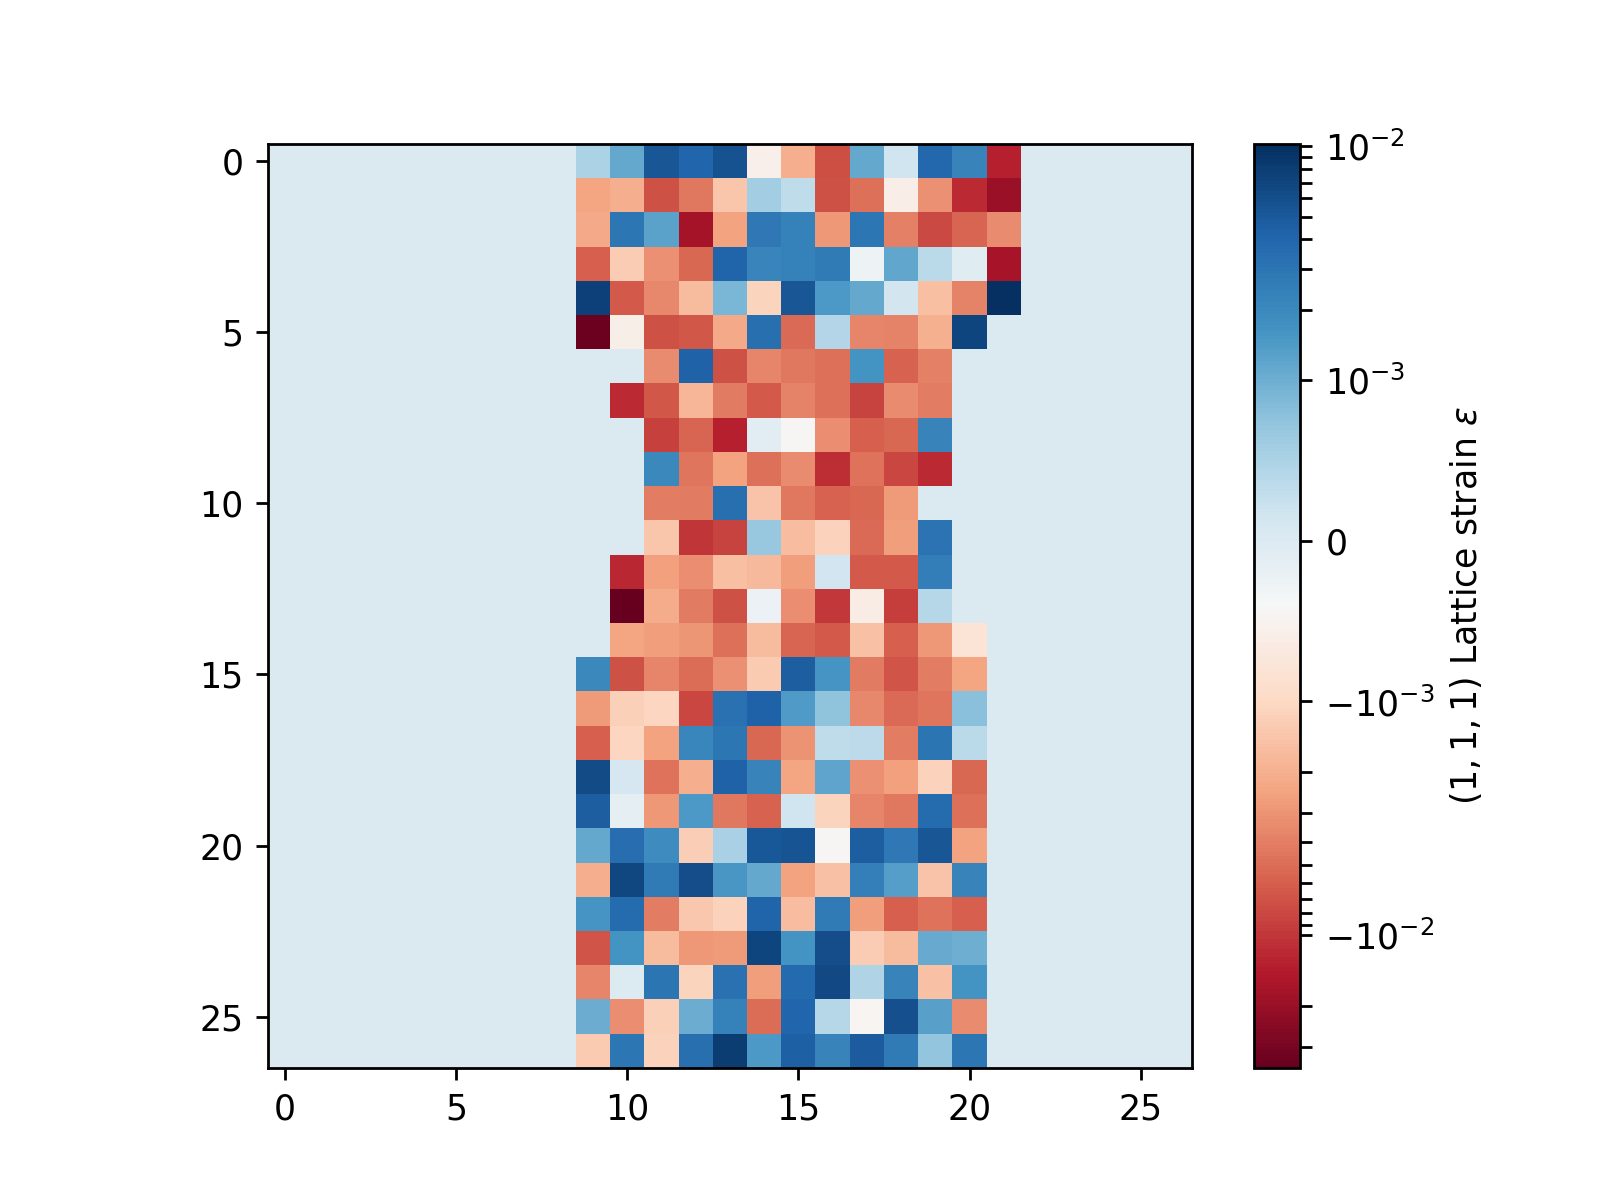

Saving /Users/spu92482/ownCloud2/RAL_Mantid_Sep2018/output/011_tileplot_color_27xy_    <scipp.Variable>          float64    [Å]            ()  [0.033225]
usbin_0.8thresh_-0.050-0.050plotthresh_initintegr_2.029A_(1, 1, 1).pdf and .png.
Plotting color-coded tile plot of Bragg edge (2, 0, 0).


<IPython.core.display.Javascript object>


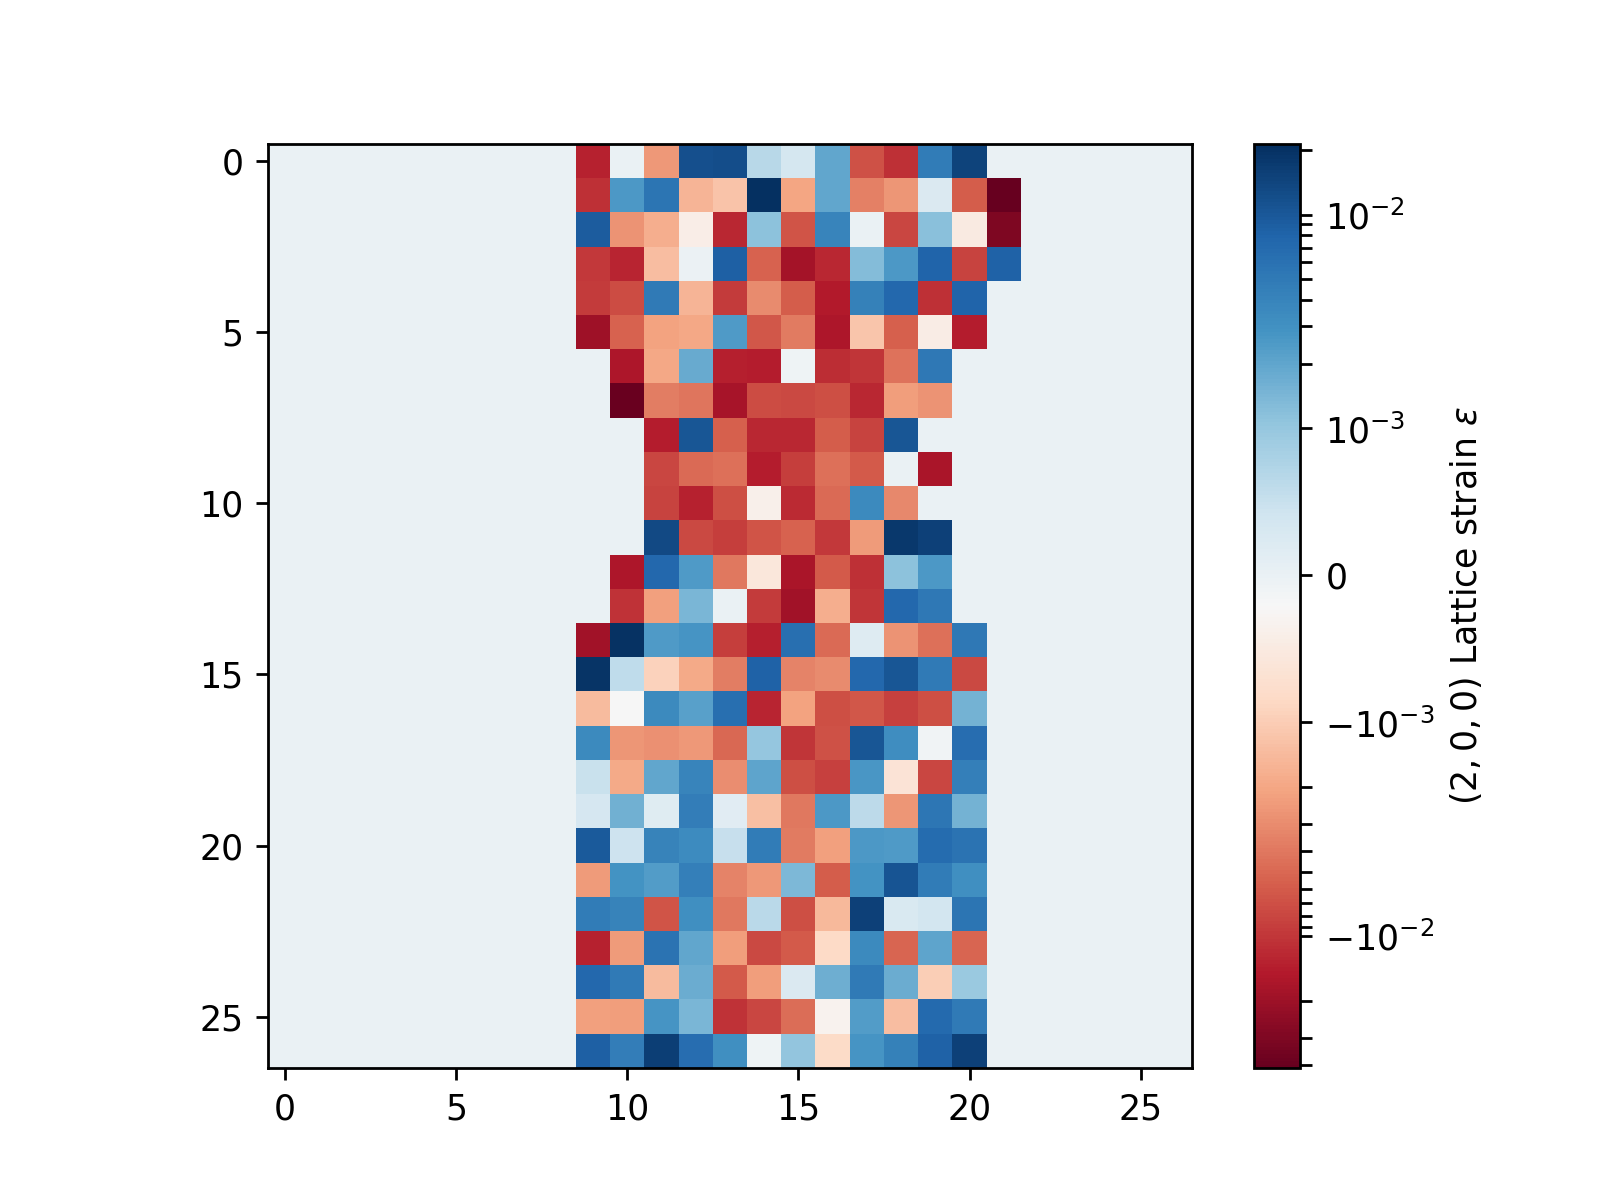

Saving /Users/spu92482/ownCloud2/RAL_Mantid_Sep2018/output/011_tileplot_color_27xy_    <scipp.Variable>          float64    [Å]            ()  [0.033225]
usbin_0.8thresh_-0.050-0.050plotthresh_initintegr_1.758A_(2, 0, 0).pdf and .png.
Plotting color-coded tile plot of Bragg edge (2, 2, 0).


<IPython.core.display.Javascript object>


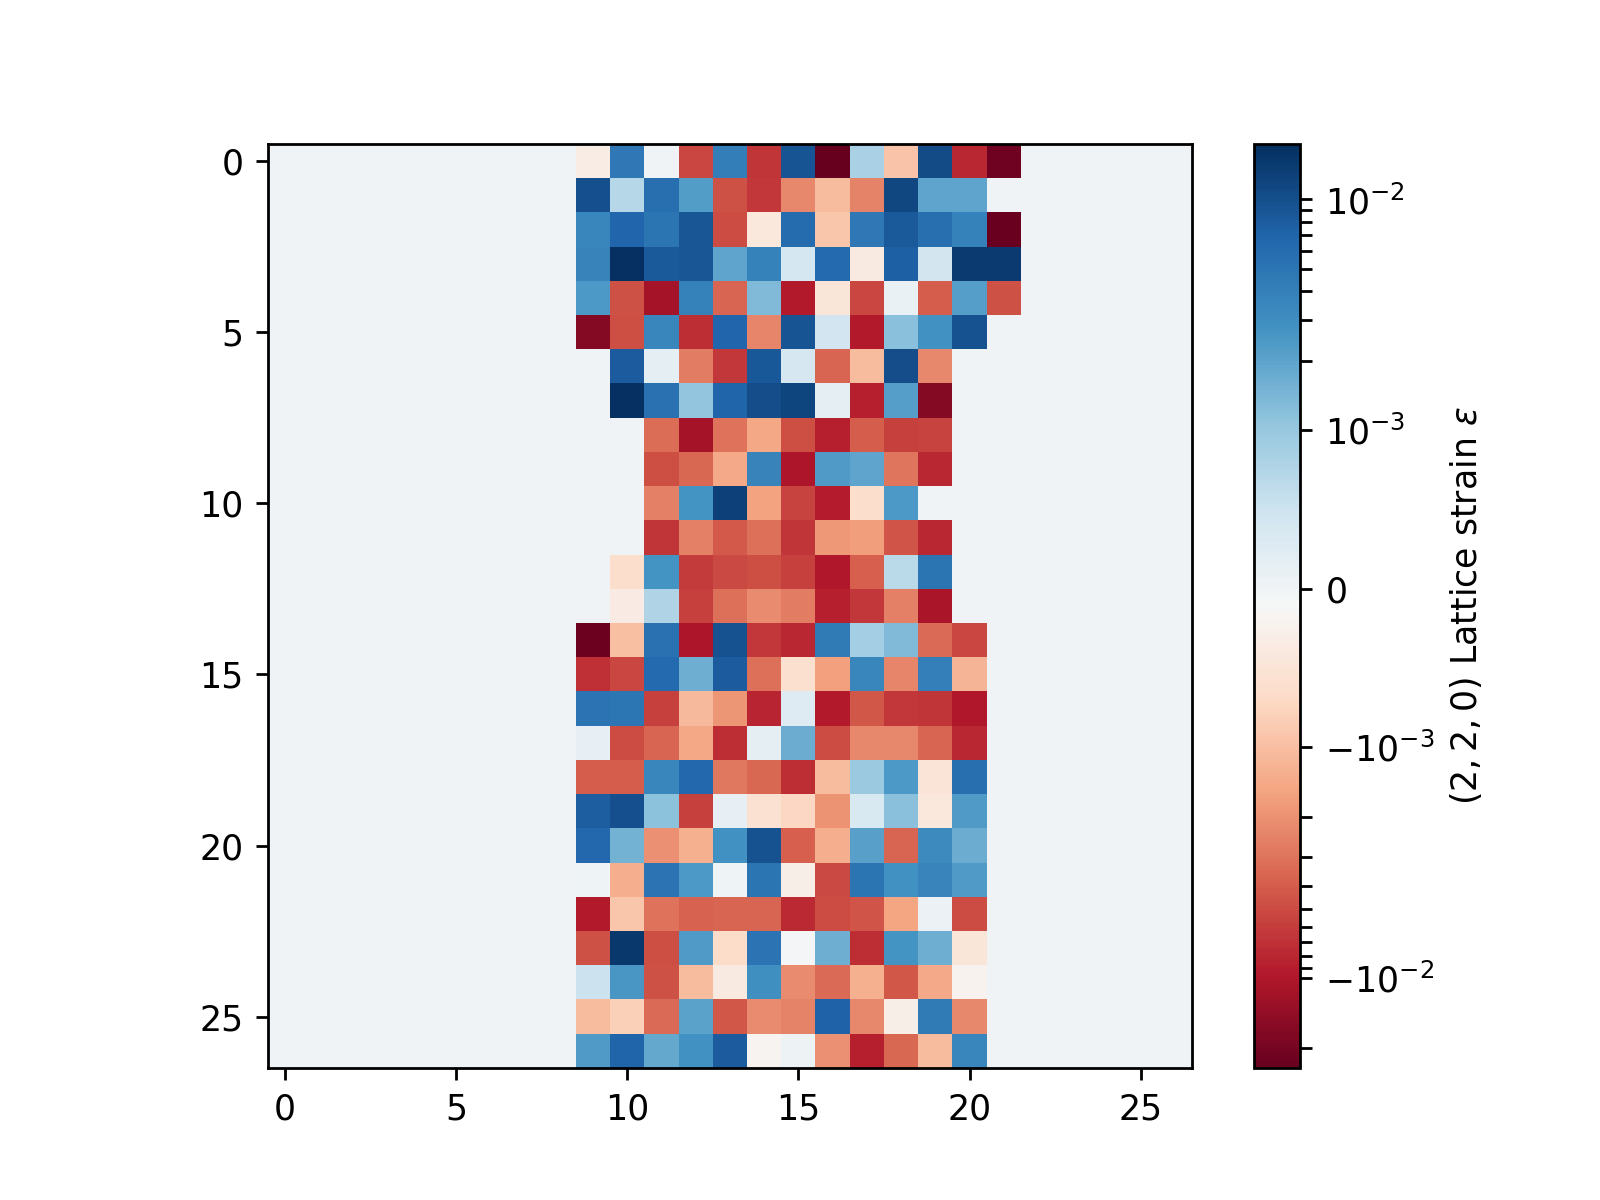

Saving /Users/spu92482/ownCloud2/RAL_Mantid_Sep2018/output/011_tileplot_color_27xy_    <scipp.Variable>          float64    [Å]            ()  [0.033225]
usbin_0.8thresh_-0.050-0.050plotthresh_initintegr_1.235A_(2, 2, 0).pdf and .png.
Plotting color-coded tile plot of Bragg edge (3, 1, 1).


<IPython.core.display.Javascript object>


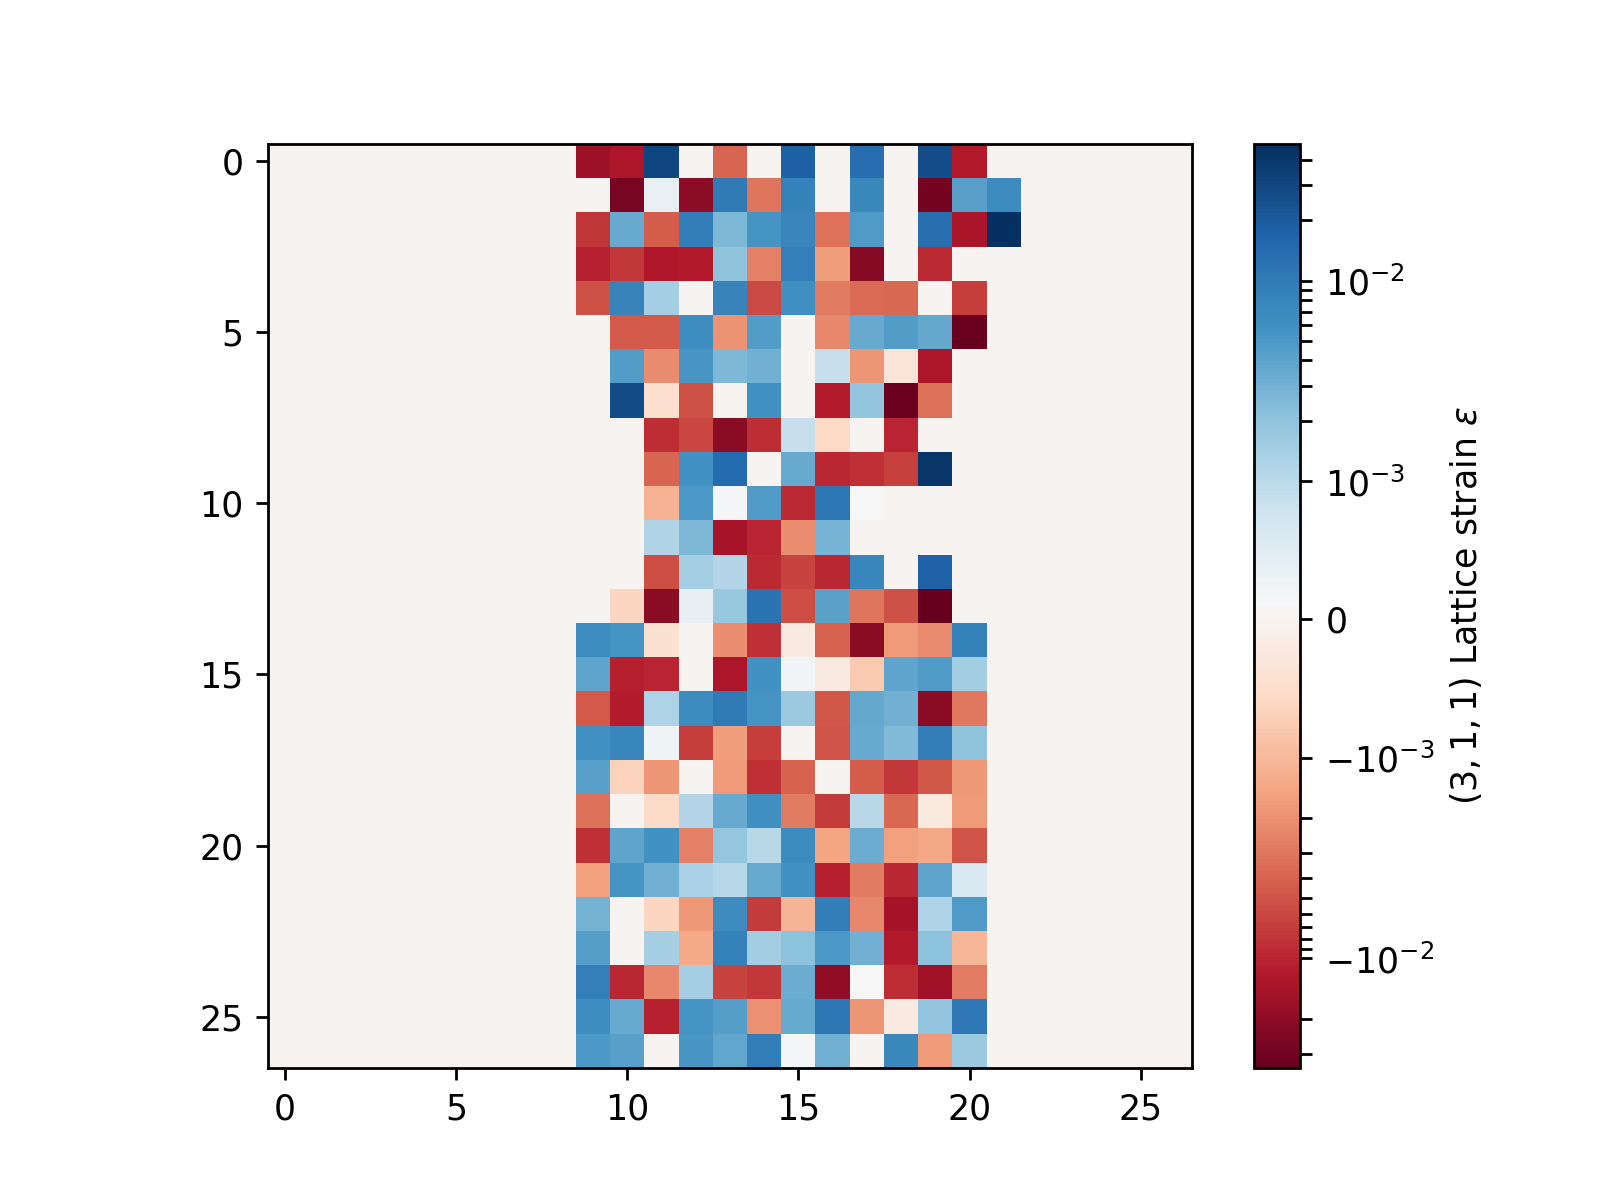

Saving /Users/spu92482/ownCloud2/RAL_Mantid_Sep2018/output/011_tileplot_color_27xy_    <scipp.Variable>          float64    [Å]            ()  [0.033225]
usbin_0.8thresh_-0.050-0.050plotthresh_initintegr_1.041A_(3, 1, 1).pdf and .png.


In [26]:
import matplotlib.pyplot as plt

def tileplot_colorcode(fit_list, nx_target, ny_target, outlier_threshold, output_filename_stem='tileplot_color'):
    # for each part of the fit list containing the fit values of each Bragg edge, create a color plot.
    output_filename_list = []
    for fit_be_list in fit_list:
        bragg_edge = fit_be_list[0][2].values  # the calculated Bragg edge TOF position
        d_spacing = fit_be_list[0][3] # the calculated Bragg edge TOF position
        output_filename = '{}_{:.3f}A_{}'.format(output_filename_stem, d_spacing.value, bragg_edge)
        # Make a 2D image of the strain values
        print(('Plotting color-coded tile plot of Bragg edge {}.'.format(bragg_edge)))
        fig, ax = plt.subplots()
        strains = np.zeros([ny_target, nx_target])
        plots_counter = 0
        for row in range(ny_target):
            for col in range(nx_target):
                if (fit_be_list[plots_counter][-1] and outlier_threshold[0] < fit_be_list[plots_counter][-2].value < outlier_threshold[1]):
                    strains[row, col] = fit_be_list[plots_counter][-2].value
                plots_counter += 1
        import matplotlib.colors as colors
        im = ax.imshow(strains, origin="upper", norm=colors.SymLogNorm(linthresh=1.0e-3), cmap="RdBu")
        cb = plt.colorbar(im)
        cb.set_label("${}$ Lattice strain $\\varepsilon$".format(bragg_edge))
        print(f'Saving {output_filename}.pdf and .png.')
        fig.savefig("{}.pdf".format(output_filename), bbox_inches="tight")
        fig.savefig("{}.png".format(output_filename), bbox_inches="tight")
        output_filename_list.append(output_filename)
    return output_filename_list



# i.e. -1e-2, 1e-2 means only -1% to 1% values of lattice strain are shown
outlier_threshold_color_plot = (-5e-2, 5e-2)

output_filename_tileplot_color ='{:03d}_tileplot_color_{}xy_{}usbin_{}thresh_{:.3f}-{:.3f}plotthresh_initintegr'.format(
                        measurement_number,grouping_number,bin_width,masking_threshold,
                        outlier_threshold_color_plot[0], outlier_threshold_color_plot[1])

fignames_col = tileplot_colorcode(fit_list=fit_list, nx_target=nx_target, ny_target=ny_target,
                                  outlier_threshold=outlier_threshold_color_plot,
                                  output_filename_stem=os.path.join(output_dir, output_filename_tileplot_color))

## Generate tile plots for single fig.

In [ ]:
def edges_to_centers(x):
    """
    Convert array edges to centers
    """
    return 0.5 * (x[1:] + x[:-1])

def tileplot(x_min_plot,x_max_plot,y_min_plot,y_max_plot,x_size,y_size,
             histogram_matrices,fitted_data, plots, fit_list, output_filename='tileplot_curves'):

    fig, ax = plt.subplots(x_size, y_size, figsize=(12, 12))

    labels = ["Without load", "Elastic deformation"]
    markers = ["o", "s"]
    # Plot some fake data so that we can have larger markers in the legend
    ax[0][0].plot([0, 1], [0, 1], ls="None", marker=markers[0], markersize=4, label=labels[0], color="C0")
    ax[0][0].plot([0, 1], [0, 1], ls="None", marker=markers[1], markersize=4, label=labels[1], color="C1")

    # All bins are identical in a dataset
    x0_nostrain = edges_to_centers(histogram_matrices[0].coords["wavelength"].values)

    # x and y values of inital state, samples without strain
    y0_nostrain = histogram_matrices[0].values

    plots_counter = 0
    for row in range(y_size):
        for col in range(x_size):
            # for running workspace index
            ws_index = plots[plots_counter][0]

            # if the whole inital-sample-state is just one spectrum, always plot that.
            # Plot no-strain curve, inital state of sample
            ax[row][col].plot(x0_nostrain, y0_nostrain, ls="None", marker= "o", markersize=1)

            # Plot curves of other states given in histogram_matrices
            for k in range(len(histogram_matrices)):
                    x0 = edges_to_centers(histogram_matrices[1].coords["wavelength"].values)
                    y0 = histogram_matrices[1]["spectrum_mapping", int(ws_index)].values
                    ax[row][col].plot(x0, y0, ls="None", marker=markers[k], markersize=1)

            # plotting the fitted spectra:
            x1 = edges_to_centers(fitted_data[0][plots_counter][0])
            x2 = edges_to_centers(fitted_data[1][plots_counter][0])
            ax[row][col].plot(x1, fitted_data[0][plots_counter][1], label="{} fit".format(labels[0]), lw=1, zorder=3)
            ax[row][col].plot(x2, fitted_data[1][plots_counter][1], label="{} fit".format(labels[1]), lw=1, zorder=3)

            # Set axis limits
            ax[row][col].set_xlim([x_min_plot, x_max_plot])
            ax[row][col].set_ylim([y_min_plot, y_max_plot])
            if col == x_size - 1:
                ax[row][col].yaxis.tick_right()
            else:
                ax[row][col].set_yticklabels([])
            if row == 0:
                ax[row][col].xaxis.tick_top()
            else:
                ax[row][col].set_xticklabels([])
            ax[row][col].tick_params(axis="x", direction="in", bottom=True, top=True)
            ax[row][col].tick_params(axis="y", direction="in", left=True, right=True)

            if row == y_size - 1:
                ax[row][col].text(0.0, -0.1, "{:.1f}".format(0.1 * col),
                                ha='center',va='top', transform=ax[row][col].transAxes)
            if col == 0:
                ax[row][col].text(-0.1, 0.0, "{:.1f}".format(0.1*(y_size - row - 1)),
                                ha='right',va='center', transform=ax[row][col].transAxes)

            if fit_list[plots_counter][-1]: # usual sign for lattice strain is \\varepsilon
                ax[row][col].text(0.1, 0.8, "${:.3f}$".format(fit_list[plots_counter][-2].value),
                                ha='left',va='top', transform=ax[row][col].transAxes, fontsize=4)
            plots_counter += 1

    # Last bin edge for xy coordinates
    ax[-1][-1].text(1.0, -0.1, "{:.1f}".format(0.1 * x_size),
                    ha='center',va='top', transform=ax[-1][-1].transAxes)
    ax[0][0].text(-0.1, 1.0, "{:.1f}".format(0.1 * y_size),
                  ha='right',va='center', transform=ax[0][0].transAxes)
    # Display only one legend
    ax[0][0].legend(loc=(0, 1.8), ncol=4)
    fig.text(0.5, 0.905, "Wavelength $[\mathrm{\AA}]$")
    fig.text(0.94, 0.5, "Counts", rotation=90, ha='center',va='center')
    fig.text(0.5, 0.075, "X position [m]")
    fig.text(0.09, 0.5, "Y position [m]", rotation=90, ha='center',va='center')
    # Remove white space between subplots
    fig.subplots_adjust(wspace=0.0, hspace=0.0)
    print(('Saving {}.pdf.').format(output_filename))
    fig.savefig("{}.pdf".format(output_filename), bbox_inches="tight")
    fig.savefig("{}.png".format(output_filename), bbox_inches="tight")
    return output_filename

output_filename_tileplot = '{:03d}_tileplot_curves_{}xy_{}usbin_{}thresh_initintegr'\
    .format(measurement_number,grouping_number,bin_width,
            masking_threshold)

# Plotting: y_min_plot=200,y_max_plot=270 for 18x18, y_min_plot=90,y_max_plot=120 for 27x27.
plotting_win = [(i*(1-.135), i*(1+.135)) for i in Bragg_edges_FCC.values]
for i in range(Bragg_edges_FCC.values.shape[0]):
    angstrom_val = Bragg_edges_FCC["bragg-edge", i].value / 2.
    lattice_indicies = Bragg_edges_FCC.coords["miller-indices"]["bragg-edge", i].value
    output_filename_tileplot_new = '{}_{:.3f}A_({})'.format(output_filename_tileplot, angstrom_val, lattice_indicies)

    win = plotting_win[i]
    fignames_curve = tileplot(
        x_min_plot=win[0], x_max_plot=win[1],
        y_min_plot=65610./(nx_target*ny_target), y_max_plot=87480./(nx_target*ny_target), # remove 0.9 later
        x_size=nx_target, y_size=ny_target,
        histogram_matrices=histogram_matrices,
        fitted_data=[spectrum_list_fitted_sample[i], spectrum_list_fitted_sample_elastic[i]],
        plots=plots, fit_list=fit_list[i], output_filename=os.path.join(output_dir, output_filename_tileplot_new))